KEY WORD:

Embedding, Embedding Projector, Integer-Encoding

# Representing text as numbers
机器学习模型将数字Vector作为输入，那么text如何输入？我们需要将text转化为数字Vector，方法如下： （本次运用的方法都无法体现text中不同word之间的顺序关系）
1. one-hot

one-hot是经典的text在机器学习中的表达方式，其缺点是每条数据的Vector大小都是整个Vocabulary的长度，数据矩阵很大可能性是稀疏的，因此效率很低。

2. Integer-Encoding

把每个词汇表示成一个数字，这个方法效率高，因为数据矩阵一定是稠密的。 并且可以体现出
一定的顺序关系。但是，词汇和数字的对应关系是完全随机的，无法体现出词汇之间的关系。 比如说，在机器学习中，某个输入为[1,999,..],这条输入前两个数据的差异会对模型参数带来较大影响，但是实际中这影响并没有实际意义。

3. Word embedding

Word embedding 把text转化为一堆浮点数。 An embeeding is a dense vector of floating point values（The lengthe of the vector is a parameter you specify）.

In [0]:
# set up
! pip install -q tf-nightly
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tdfs.disable_progress_bar()

In [0]:
# ** JUST an example from keras.layers.embedding

import numpy as np
model = keras.Sequential()
model.add(layers.Embedding(1000, 64, input_length=10))
# the model will take as input an integer matrix of size (batch,
# input_length).
# the largest integer (i.e. word index) in the input should be no larger
# than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch
# dimension.

input_array = np.random.randint(1000, size=(32, 10))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
assert output_array.shape == (32, 10, 64)

In [0]:
# embedding imlementation

embedding_layer = layers.Embedding(1000, 5)
# embedding 会初始化W（权值），W会随着前馈更新。一旦训练后，embedding可以大体上编码词汇之间的相似度关系

# 如果你将一个Int传入embedding层，结果会把Int替换为从embedding table查找出的向量

result = embedding_layer(tf.constant([[1,2,3],[4,5,6]]))
result.numpy()

array([[[-0.02182128, -0.03615363,  0.04407891,  0.0109274 ,
         -0.04587669],
        [ 0.01192899,  0.02608598, -0.03027564, -0.02010862,
         -0.04398817],
        [ 0.03892237,  0.00068573, -0.02380228,  0.04867423,
          0.02925899]],

       [[ 0.02247547, -0.03116169,  0.0123176 , -0.00340308,
         -0.01889256],
        [-0.01102257, -0.030169  , -0.03102337,  0.01961339,
         -0.01036678],
        [ 0.04716342,  0.04779247,  0.01146233,  0.0121388 ,
          0.03851357]]], dtype=float32)

In [0]:
# task: train a sentiment classifer on IMDB movie reviews. In last movie review we used the Integer_Encoding.
(train_data, test_data) , info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info = True,
    as_supervised = True
) 

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKH1U62/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKH1U62/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteKH1U62/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
# get the encoder (tf.features.text.SubwordTextEncoder)
encoder = info.features['text'].encoder
# 
encoder.subwords[:5]

['the_', ', ', '. ', 'a_', 'and_']

In [0]:
# Movie reviwes can be different lengths. 'padded_batch' moethod can standardize the lengths of the reviews.
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches  = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
# padded_shapes在tf2.2版本不再需要参数，默认所有扩大到该batch中最长。As follows
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches  = test_data.shuffle(1000).padded_batch(10)

# have a look:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[7627,   20,  979, ...,    0,    0,    0],
       [ 147,   14,   32, ...,    0,    0,    0],
       [  62,   27,    9, ...,    0,    0,    0],
       ...,
       [  12,  176,  109, ..., 2595, 1155, 7975],
       [5646,    2,   14, ...,    0,    0,    0],
       [2883,  798,  968, ...,    0,    0,    0]])

In [0]:
# Embedding layer takes the integer-encoded vocabulary and looks up the 
#     embedding vector for each word-index.
# GlobalAveragePooling1D layer returns a fixed-length output vector for each 
#     example by averaging over the sequence dimension. 
#     (batch_size, steps, features) -> (batch_size, features): sum(all_features) / steps
embedding_dim = 16
model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20
)

Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.5092 - accuracy: 0.7006 - val_loss: 0.3800 - val_accuracy: 0.8450
Epoch 2/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2828 - accuracy: 0.8844 - val_loss: 0.3615 - val_accuracy: 0.8450
Epoch 3/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2296 - accuracy: 0.9089 - val_loss: 0.3202 - val_accuracy: 0.8850
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1977 - accuracy: 0.9245 - val_loss: 0.4459 - val_accuracy: 0.8250
Epoch 5/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1741 - accuracy: 0.9362 - val_loss: 0.4478 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1569 - accuracy: 0.9430 - val_loss: 0.5729 - val_accuracy: 0.8300
Epoch 7/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1432 - accuracy: 0.9470 - val_loss: 0.3851 - val_ac

# Evaluation


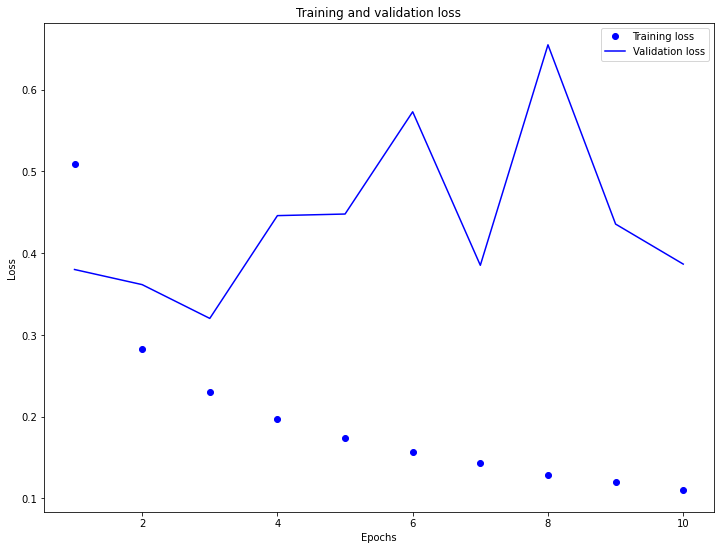

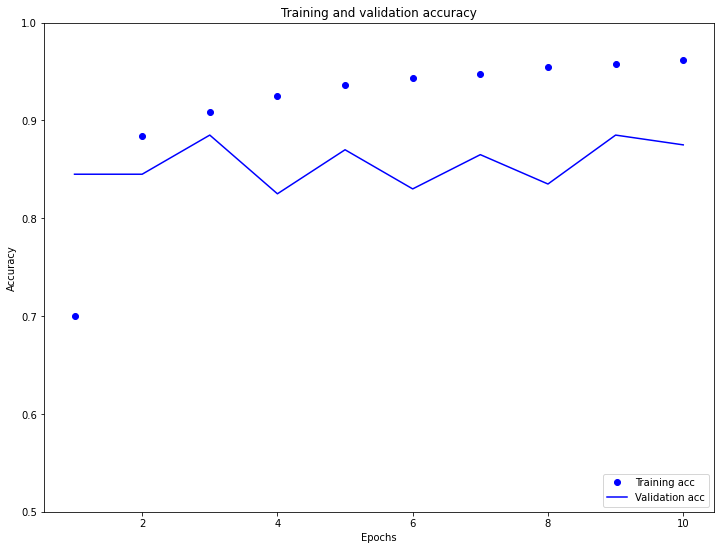

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

# Retrive the learned embeddings.

Next, let's retrive the word embeddings learned during training. This will be a matrix of shape (vovab_size, embedding-dimension).

Then we will write the weights to disk. Use 'Embedding Projector'.

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [0]:
# We will now write the weights into disk. We will upload 2 files in tab
# seperated format: a file of vectors (contains the embedding), and a file 
# of meta data (containing the words)
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')